In [1]:
import numpy as np
import pandas as pd
import finance_toolkit as fin

%load_ext autoreload
%autoreload 2

$$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$$

$$B(t) = \frac{1}{(1+r)^t}$$

In [2]:
def discount(t, r):
    return (1+r)**(-t)

In [3]:
b = discount(10, .03)
b

0.7440939148967249

In [4]:
b*(1.03**10)

1.0

In [5]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])

In [6]:
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [7]:
discounts = discount(liabilities.index, 0.03)

In [8]:
discounts

Float64Index([0.9151416593531595, 0.9017158706285221, 0.8884870479156888,
              0.8754523015810894],
             dtype='float64')

In [9]:
discounts * liabilities

3.0    0.915142
3.5    1.352574
4.0    1.776974
4.5    2.188631
dtype: float64

In [10]:
(discounts * liabilities).sum()

6.233320315080045

In [11]:
def pv(l, r):
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

In [12]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return assets/pv(liabilities, r)

In [13]:
funding_ratio(5, liabilities, 0.03)

0.8021407126958777

In [14]:
funding_ratio(5, liabilities, 0.02)

0.7720304366941648

In [15]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f'{fr*100:.2f}%')
    
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01)
)
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

$$\left(1+\frac{r}{N}\right)^N$$


In [16]:
(1+1/4)**4

2.44140625

In [17]:
(1+1/10)**10

2.5937424601000023

In [18]:
(1+1/100000)**100000

2.7182682371922975

In [19]:
np.exp(1)

2.718281828459045

In [20]:
def inst_to_ann(r):
    return np.expm1(r)

def ann_to_inst(r):
    return np.log1p(r)


$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

In [21]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # just in case of roundoff errors going negative
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

<Axes: >

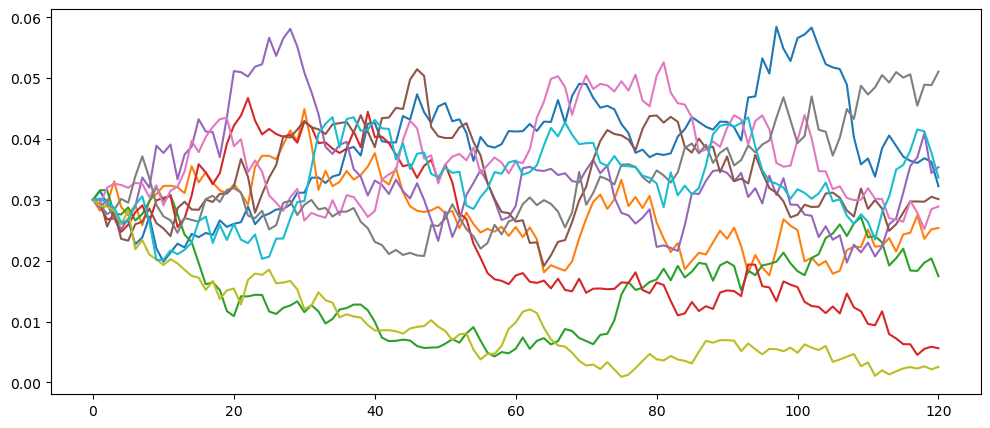

In [22]:
cir(n_scenarios=10).plot(legend=False, figsize=(12,5))

In [23]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))

import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [24]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [53]:
import statsmodels.stats.moment_helpers as mh

In [25]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …